<a href="https://colab.research.google.com/github/Doquey/SVOTrajetoria/blob/main/SVOTrajetoriaCarro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup Inicial

# Problema: Com base em imagens tiradas em um carro em movimento por duas cameras em lados opostos do carro, desenhar a trajetoria desse carro

In [ ]:
%tensorflow_version 2.x

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True) 

Mounted at /content/drive/


In [ ]:
!pip uninstall opencv-python

In [ ]:
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
import cv2 as cv
import numpy as np
import pandas as pd
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

Teoria: 

Oque vamos utilizar aqui é o chamado SVO(Stereo-Visual-odometry) existem diversas formas de se trabalhar com SVO, porem oque vamos fazer aqui é o seguinte: 
Vamos utilizar um feature descriptor para extrair features das imagens. Vamos transformar essas features em 3D point clouds ,utilizando de um mapa de disparidades entre a camera esquerda e direita para conseguirmos o mapa de profundidade para acrescentar profundidade as features(transformar as features para o campo 3D). Feito isso nos vamos reprojetar os point clouds no plano 2D(no proximo frame) e vamos calcular a distância entre features correspondentes a fim de minimizar essa distância e obtermos a matriz de transformação que nos dara a trajetoria.

In [ ]:
base_dir = '/content/drive/My Drive/Colab Notebooks/Daedalus Problemas/Problema2/'

In [ ]:
#Criamos uma Classe calib para guardar as nossas matrizes de projeção 
class calib():
  def __init__(self,base_dir):
    calib = pd.read_csv(base_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
    self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
    self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
    self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
    self.P3 = np.array(calib.loc['P3:']).reshape((3,4))

In [ ]:
#Função para pegar as imagens
def _load_images(filepath):
  image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
  images = [cv.imread(path, cv.IMREAD_GRAYSCALE) for path in image_paths]
  return images

def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
   
    #Esses são valores otimos de acordo com a documentação do openCV
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
        img_right = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    
    return disp_left

def decompose_projection_matrix(p):
    #fazemos a decomposição da nossa matriz de projeção
    #note que usaremos a matriz intrinsica k para calcularmos o mapa de profundidade de cada imagem.
    k, r, t, _, _, _, _ = cv.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t



def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    
    #pega o comprimento focal horizontal da camera esquerda
    f = k_left[0][0]
    
    # Calculamos a distância entre as duas cameras.
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    #setamos partes da imagem inuteis para os nossos algoritimos como tendo disparidade 0.1, ou tendo uma profundidade absurda na imagem
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    #Criamos o mapa de profundidade 
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map


def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
   #Função que calcula direto o depth_map utilizando duas imagens
    # Primeiro computados a disparidade entre as imagens
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Fazemos a decomposição das matrizes de projeção
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculamos o depth_map 
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth


def extract_features(image, detector='sift', mask=None):
    #com base em qual algoritimo detector vamos usar, calculamos os keypoints e pegamos os features descriptors
    if detector == 'sift':
        det = cv.xfeatures2d.SIFT_create()
    elif detector == 'orb':
        det = cv.ORB_create()
    elif detector == 'surf':
        det = cv.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    #retornamos os keypoints 
    return kp, des

def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    #utilizaremos os features descriptors para analisar se uma feature é match de uma outra.
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv.BFMatcher_create(cv.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv.BFMatcher_create(cv.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches


def filter_matches_distance(matches, dist_threshold):
    #Aqui pegamos os features matches de duas imagens e comparamos a distância entre cada um deles com um threshold. Caso a distância seja menor que o threshold, definimos aquele
    #match como um bom match, caso contrario discartamos.
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match







def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            if z > max_depth:
                delete.append(i)
                continue
                
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # utilizamos o PNPRANSAC algorithm para detectar os inliers.(features presentes em ambas imagens)
        _, rvec, tvec, inliers = cv.solvePnPRansac(object_points, image2_points, k, None)
        
        rmat = cv.Rodrigues(rvec)[0]
    
    return rmat, tvec, image1_points, image2_points








def visual_odometry(images_0,images_1,calib, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,plot=True):
  
  

    
        
    num_frames = len(images_0)
        

        
    #estabelecemos a trajetoria, que é no nosso caso a matriz de transformação do mundo 3D para a imagem esquerda de frame a frame.   
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = images_0[0].shape[0]
    imwidth = images_0[1].shape[1]
    
    #Fazemos a decomposição da matrix de projeção da camera esquerda
    k_left, r_left, t_left = decompose_projection_matrix(calib.P0)
    

    
    #Fazemos um loop sobre nossos frames 
    for i in range(num_frames - 1):

        #pegamos um frame da camera esquerda, outro da camera direita e depois mais um frame da camera esquerda.
        #com esses frames faremos o seguinte: o primeiro frame da camera esquerda e o frame da camera direita serão utilizados na estimação do mapa de profundidade.
        # o primeiro frame tambem terá suas features extraidas e projetadas num point_cloud 3D. Após isso utilizaremos a matriz de transformação para projetar esses pontos novamente
        # no 2D porem no proximo frame da camera esquerda. "Arrumaremos" essa transformação até termos uma distância muito pequena entre os pontos correspondentes do frame 0 da camera esquerda
        # no frame 1 da camera esquerda. Quando tivermos essa transformação otimizada, a nossa trajetoria se dara por essa matriz transformação.
        image_left = images_0[i]
        image_right = images_1[i]
        image_plus1 = images_0[i+1]
        
        
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=calib.P0, 
                                   P1=calib.P1,
                                   matcher=stereo_matcher)
        
        else:
            depth = None
            
            
        #pegamos os key_points e os descriptors
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        #fazemos os matches
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
      
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        trajectory[i+1, :, :] = T_tot[:3, :]
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
      plt.close()
        
    return trajectory


Fazemos upload das imagens. Note que a função _load_images faz o upload das imagens ja em Grayscale

In [ ]:
images_0 = _load_images(base_dir+'image_0')
images_1 = _load_images(base_dir +'image_1')

Instanciamos a nossa classe e agora podemos chamar as matrizes P0 e P1 de projeção das cameras Grayscale quando quisermos

In [ ]:
calib= calib(base_dir +'calib/')

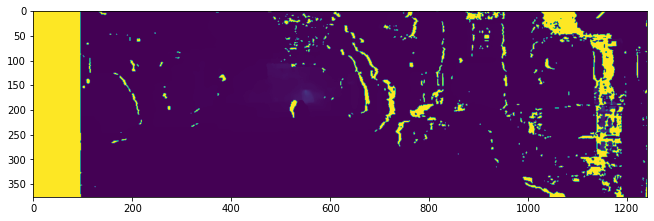

In [ ]:
P0 = calib.P0
P1 = calib.P1
disp = compute_left_disparity_map(images_0[0],images_1[0],'sgbm')
k,r,t = decompose_projection_matrix(P0)
k1,r1,t1 = decompose_projection_matrix(P1)
depth_map = calc_depth_map(disp,k,t,t1)

plt.figure(figsize=(11,7))
plt.imshow(depth_map);

Note que a parte amarela da imagem acima são os valores que setamos na calc_depth_map como 0.1, a cor amarelada significa que esses pixeis tem uma profundidade muito grande, tão grande que é possivel separa-los facilmente do restante da imagem e faremos isso agora de forma a evitar que os nossos algoritimos de detecção de features percam tempo passando filtros nessas regiões.
Nota: Podemos fazer isso porque esses pixeis serão inuteis nos nossos calculos, pois por exemplo, a listra amarela na parte esquerda da imagem acima é uma parte onde a camera referência(camera esquerda) não tem visão alguma.

Vamos então delimitar aonde essa listra termina 

In [ ]:
for i,pixel in enumerate(depth_map[0]):
  if pixel < depth_map.max():
    print('A listra termina na coluna de pixeis {}'.format(i))
    break

A listra termina na coluna de pixeis 96


Portanto podemos criar uma mask para nossa imagem que pegue valores dessa coluna adiante

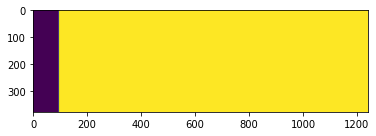

In [ ]:
mask = np.zeros(depth_map.shape,dtype='uint8')
xmax = depth_map.shape[1]
ymax = depth_map.shape[0]

cv.rectangle(mask,(96,0),(xmax,ymax),(255),thickness=-1)
plt.imshow(mask)

Rodamos a função que roda todo nosso codigo em bloco


Generating disparities with StereoBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.2*distance


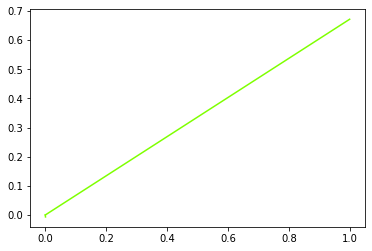

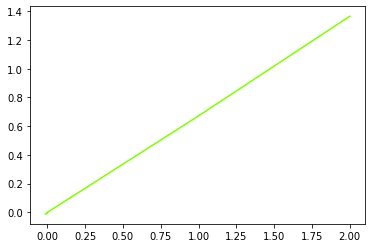

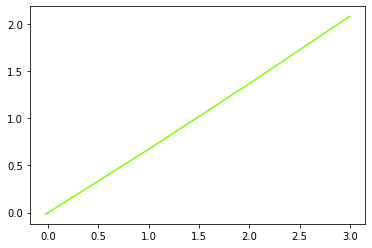

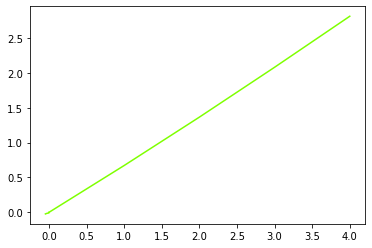

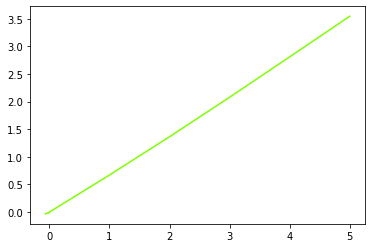

In [ ]:
trajectory_nolidar_bm = visual_odometry(images_0,images_1,calib,plot=True,detector='sift',filter_match_distance=0.2)

Plotamos a trajetoria em 3D

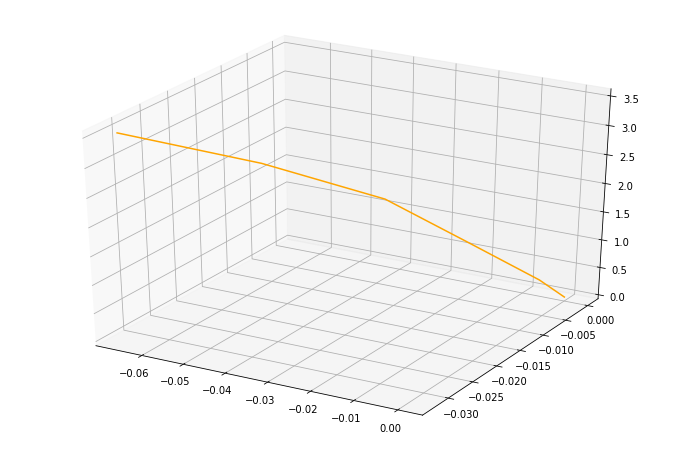

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_bm[:, :, 3][:, 0], 
        trajectory_nolidar_bm[:, :, 3][:, 1], 
        trajectory_nolidar_bm[:, :, 3][:, 2], label='estimated', color='orange')

Conclusão:

A SVO é uma tecnica poderosa para estimação da trajetoria de um veiculo em movimento. Seu poder se baseia principalmente no fato de conseguirmos não somente a trajetoria, mas sim a trajetoria em scala, porque o metodo utiliza da camera auxiliar para estimar um mapa de profundidade.

Referência:

https://github.com/FoamoftheSea/KITTI_visual_odometry/blob/main/KITTI_visual_odometry.ipynb

https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html


